In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import pandas as pd
import os
import json
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
#from bag_of_words import ParseData
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer

%load_ext autoreload
%autoreload 2

2022-04-23 23:43:59.655911: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/lib64:/usr/local/cuda/lib64
2022-04-23 23:43:59.655932: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Conferences
conf = ['acl_2017', 'arxiv.cs.ai_2007-2017', 'arxiv.cs.cl_2007-2017', 'arxiv.cs.lg_2007-2017', 'conll_2016', 'iclr_2017']

# JSON files to be parsed
dir_path    = '../PeerRead/data/'
train_path  = '/train/reviews/'
test_path   = '/test/reviews/'

In [ ]:
from Dataparser import get_all_json, create_dataframe, create_label_df, preprocess_text
import pandas as pd

datapath = '../PeerRead/data/'
paths = {
  'acl': 'acl_2017',
  'cs_ai': 'arxiv.cs.ai_2007-2017',
  'cs_cl': 'arxiv.cs.cl_2007-2017',
  'cs_lg': 'arxiv.cs.lg_2007-2017',
  'conll': 'conll_2016',
  'iclr': 'iclr_2017',
  'nips': 'nips_2013-2017'
}

dataset_names = ['acl', 'cs_ai', 'cs_cl', 'cs_lg', 'conll', 'iclr']
num_datasets = len(dataset_names)
dataset_data = [get_all_json(datapath + paths[s]) for s in dataset_names]

parent_paths = [datapath + paths[s] for s in dataset_names]
review_paths = sum([[path + '/dev/reviews', path + '/test/reviews', path + '/train/reviews'] for path in parent_paths], [])

testing_data = [create_dataframe(data[4], data[5], dataset_name=i) for i,data in enumerate(dataset_data)]
training_data = [create_dataframe(data[2], data[3]) for data in dataset_data]

testing_dfs = [pd.DataFrame(testing_data[i]) for i in range(num_datasets)]
training_dfs = [pd.DataFrame(training_data[i]) for i in range(num_datasets)]

### only labels
'''
test_label_data = [create_label_df(review_path,testing_df=testing_dfs[i//3]) for i, review_path in enumerate(review_paths)]
train_label_data = [create_label_df(review_path,testing_df=training_dfs[i//3]) for i, review_path in enumerate(review_paths)]


test_label_dfs = [pd.DataFrame(test_label_data[i]) for i in range(num_datasets)]
train_label_dfs = [pd.DataFrame(train_label_data[i]) for i in range(num_datasets)]
'''
##
testing_dfs[1]

In [ ]:
#numpy_arr = testing_dfs[1].values[:, 1:]
print(len(testing_data), len(training_data[1]))

#print(training_data)

train_title = []
test_title  = []
train_label = []
test_label  = []

print(len(training_data), len(training_data[0]), len(training_data[0][0]), training_data[0][0].keys())

for i in range(num_datasets):  
    for n in range(len(training_data[i])):
        #print(training_data[i][n]['title'])
        train_title.extend([training_data[i][n]['title']])
        train_label.extend([training_data[i][n]['accepted']])
        
    for k in range(len(testing_data[i])):
        test_title.extend([testing_data[i][k]['title']])
        test_label.extend([testing_data[i][k]['accepted']])

## support for old code
merged_data = []
merged_data.extend(train_title)
merged_data.extend(test_title)

## title only test
train_data = train_title
test_data = test_title

len(merged_data)

In [18]:
from Dataparser import preprocess_text

# Getting bag of words definition from our corpus of data
bowVec = CountVectorizer(ngram_range=(1,1), preprocessor=preprocess_text, stop_words='english')
bowVec = bowVec.fit(merged_data)

## get BOW feature rep
X_train = bowVec.transform(train_data)  
X_test = bowVec.transform(test_data)

print(X_train.shape, len(train_data))

## display 
cv_dataframe = pd.DataFrame(X_train.toarray(),columns=bowVec.get_feature_names_out())
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
display(cv_dataframe.head(5).loc[:,cv_dataframe.head(5).any()])

(637, 9172) 637


,analysis,argument,based,chunk,coherence,comprehension,decoder,evaluation,interactions,japanese,...,morphology,multi,neural,predicate,prerequisite,readability,reading,skills,structure,translation
0,1,1,0,0,0,0,0,0,1,1,...,0,1,1,2,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
2,0,0,1,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,1,1,1,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [22]:
# Dimension reduction on BOW using SVD
on_svd = False

svd = TruncatedSVD(n_components=500, n_iter=10, random_state=42)
X_new = svd.fit(X_train)
X_train_svd = svd.transform(X_train)
X_test_svd = svd.transform(X_test)

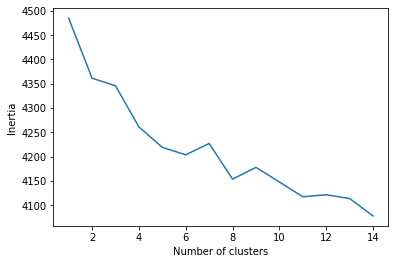

In [23]:
# Cluster documents based on BOW model
bow_distortions = []
K = range(1,15)

for k in K:
    bow_model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10)
    if(on_svd):
        bow_model.fit(X_train_svd)
    else:
        bow_model.fit(X_train)
    bow_distortions.append(bow_model.inertia_)

plt.plot(K, bow_distortions)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
# print(distortions)

# Choosing the best k from elbow method.
true_k = 6
bow_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=10)

if(on_svd):
    bow_model.fit(X_train_svd)
else:
    bow_model.fit(X_train)

Top terms per cluster:


/home/inspire/miniconda3/envs/ml_hw3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


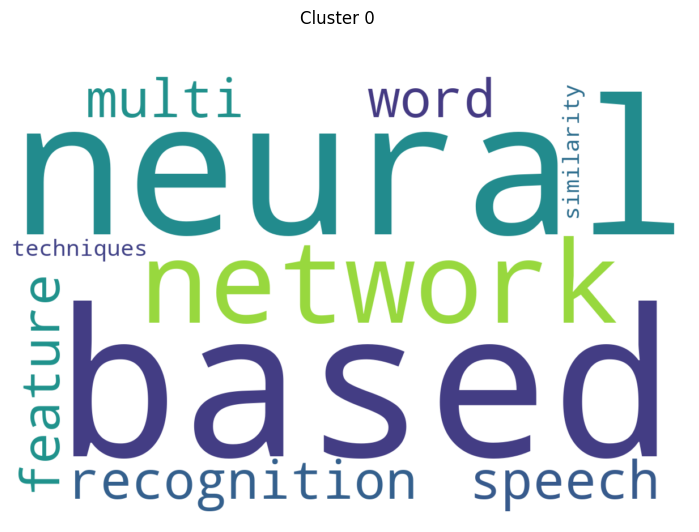

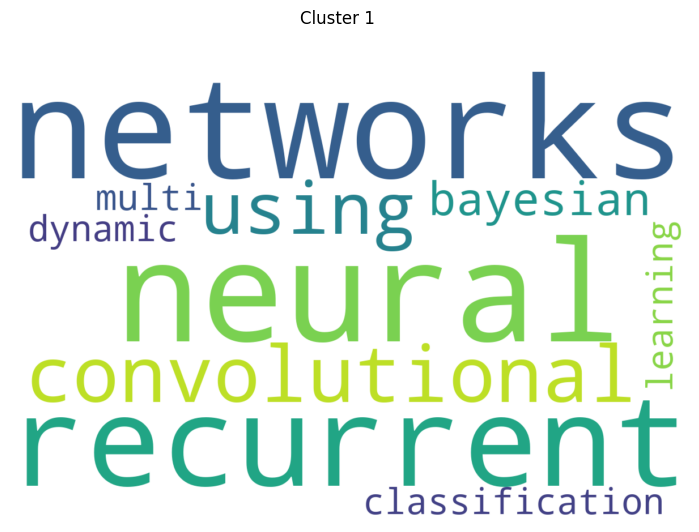

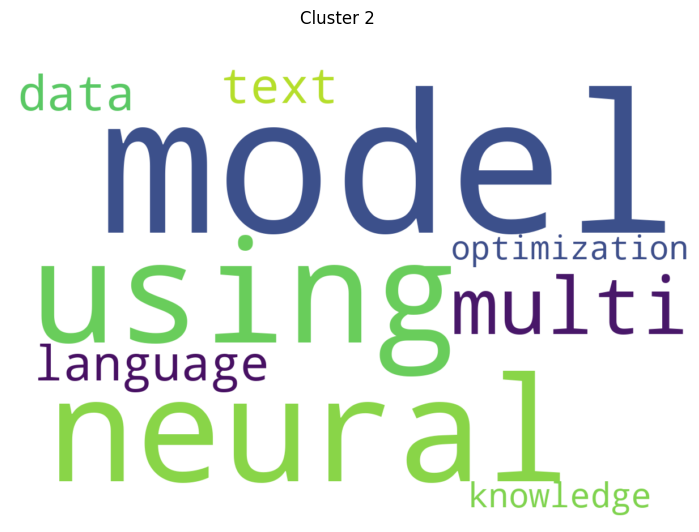

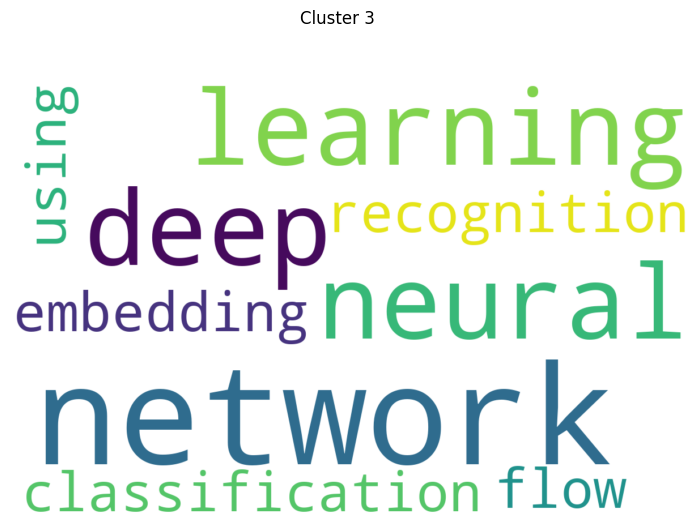

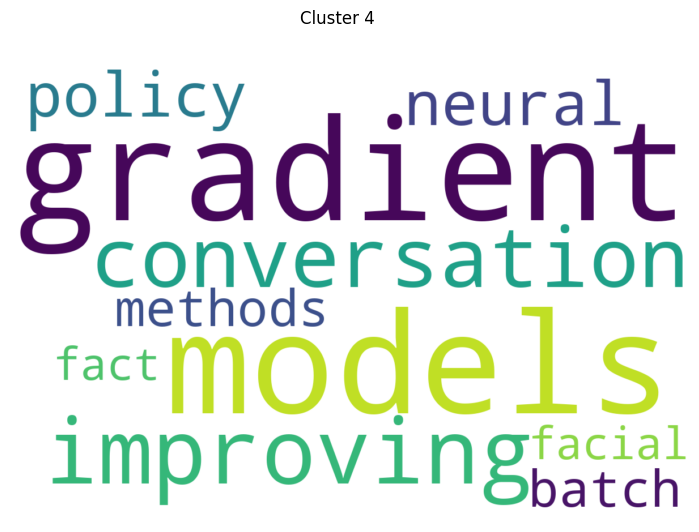

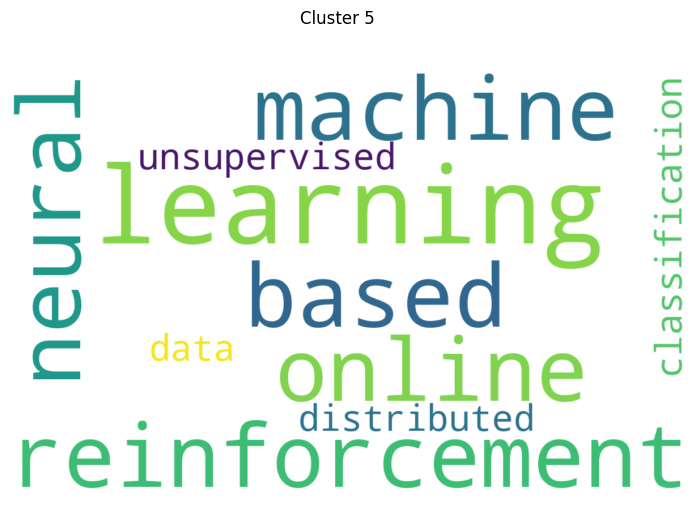

In [25]:
# Print top terms per cluster and generate word clouds for BOW model
print("Top terms per cluster:")
bow_order_centroids = bow_model.cluster_centers_.argsort()[:, ::-1]
terms = bowVec.get_feature_names()
for i in range(true_k):
    # print("Cluster %d:" % i)
    words = ""
    for ind in bow_order_centroids[i, :10]:
        words = words + terms[ind] + " "
        # print (' %s' % terms[ind])
    wordcloud = WordCloud(width=1200, height=800, background_color="white").generate(words)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    fig.suptitle(f"Cluster {i}")
    plt.show()

In [26]:
# Testing the Clustering based on BOW model
# Predict the cluster association of each paper

prediction = bow_model.predict(X_test)
print(X_train.shape)
print(X_test.shape)
df = pd.DataFrame(list(zip(test_title, prediction)), columns =['Title', 'Cluster ID'])
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# display(df)
print(df.head(10).loc[:,df.head(10).any()].to_markdown())
# display(df.loc[df['Cluster ID'] == 1])

(637, 9172)
(637, 9172)
|    | Title                                                                                                          |   Cluster ID |
|---:|:---------------------------------------------------------------------------------------------------------------|-------------:|
|  0 | An End-to-End Model for Question Answering over Knowledge Base with Cross-Attention Combining Global Knowledge |            2 |
|  1 | Ontology-Aware Token Embeddings for Prepositional Phrase Attachment                                            |            2 |
|  2 | Skip-Gram - Zipf + Uniform = Vector Additivity                                                                 |            0 |
|  3 | Universal Dependencies Parsing for Colloquial Singaporean English                                              |            2 |
|  4 | Handling Cold-Start Problem in Review Spam Detection by Jointly Embedding Texts and Behaviors                  |            2 |
|  5 | Time Expression Analysis

## Naive Bayes Classifier

In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

mygnb = GaussianNB()
mygnb = mygnb.fit(X_train.toarray(), train_label)

## test
#print(mygnb.predict(X_test[0]), test_label[0])

train_preds = mygnb.predict(X_train.toarray())
print("Train Accuracy: ", 100*accuracy_score(train_preds, train_label))

test_preds = mygnb.predict(X_test.toarray())
print("Test Accuracy: ", 100*accuracy_score(test_preds, test_label))

## visualize
RocCurveDisplay.from_estimator(mygnb, X_test.toarray(), test_label)
ConfusionMatrixDisplay.from_estimator(mygnb, X_test.toarray(), test_label)
plt.show()

Train Accuracy:  98.43014128728414


ValueError: Found input variables with inconsistent numbers of samples: [637, 11090]

## KNN Classifier

Train Accuracy:  84.7723704866562
Test Accuracy:  59.02668759811617


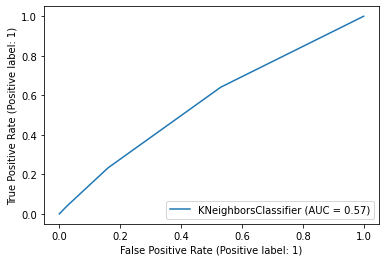

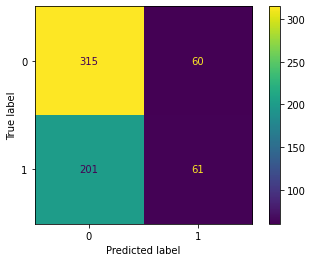

In [163]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## KNN classifier
## hyperparams
num_neighbs = 3
myKNN = KNeighborsClassifier(n_neighbors=num_neighbs)

## BOW fts
myKNN.fit(X_train, train_label)

## test
#print(neigh.predict(X_test[0]), test_label[0])

train_preds = myKNN.predict(X_train)
print("Train Accuracy: ", 100*accuracy_score(train_preds, train_label))

test_preds = myKNN.predict(X_test)
print("Test Accuracy: ", 100*accuracy_score(test_preds, test_label))

## visualize
RocCurveDisplay.from_estimator(myKNN, X_test, test_label)
ConfusionMatrixDisplay.from_estimator(myKNN, X_test, test_label)
plt.show()


## Logistic Regression 

Train Accuracy:  76.76609105180535
Test Accuracy:  60.12558869701727


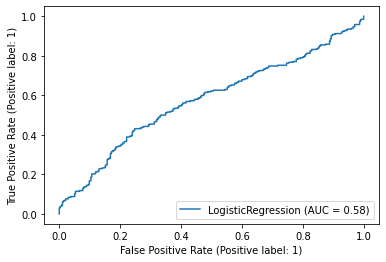

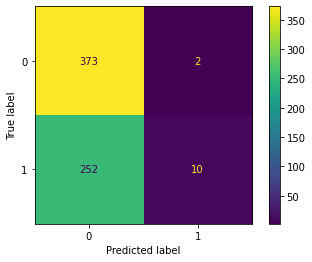

In [164]:
from sklearn.linear_model import LogisticRegression

mylreg = LogisticRegression()
mylreg = mylreg.fit(X_train, train_label)

## test
#print(mylreg.predict(X_test[0]), test_label[0])

train_preds = mylreg.predict(X_train)
print("Train Accuracy: ", 100*accuracy_score(train_preds, train_label))

test_preds = mylreg.predict(X_test)
print("Test Accuracy: ", 100*accuracy_score(test_preds, test_label))

## visualize
RocCurveDisplay.from_estimator(mylreg, X_test, test_label)
ConfusionMatrixDisplay.from_estimator(mylreg, X_test, test_label)
plt.show()

## Decision Tree Classifier

Train Accuracy:  100.0
Test Accuracy:  61.38147566718995


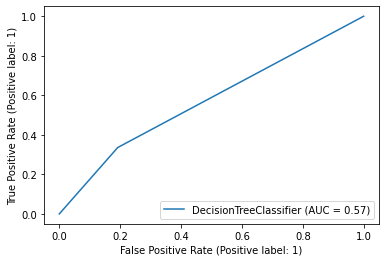

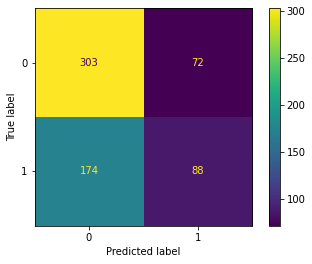

In [165]:
from sklearn import tree
from sklearn.metrics import accuracy_score

mydtree = tree.DecisionTreeClassifier()
mydtree = mydtree.fit(X_train, train_label)

## test
#print(mydtree.predict(X_test[0]), test_label[0])

train_preds = mydtree.predict(X_train)
print("Train Accuracy: ", 100*accuracy_score(train_preds, train_label))

test_preds = mydtree.predict(X_test)
print("Test Accuracy: ", 100*accuracy_score(test_preds, test_label))

## visualize
RocCurveDisplay.from_estimator(mydtree, X_test, test_label)
ConfusionMatrixDisplay.from_estimator(mydtree, X_test, test_label)
plt.show()

## Random Forest Classifier

Train Accuracy:  99.84301412872841
Test Accuracy:  61.224489795918366


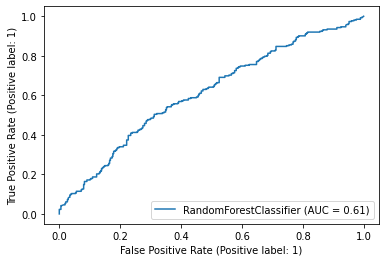

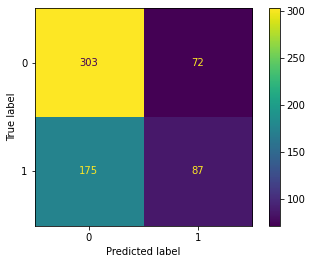

In [166]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## hyperparams
max_depth = 100#None  ## None for pure dtrees
n_estimators = 100
criterion = 'gini' #'entropy'

myrforest = RandomForestClassifier(max_depth=max_depth, n_estimators= n_estimators, criterion=criterion)
myrforest = myrforest.fit(X_train, train_label)

## test
#print(myrforest.predict(X_test[0]), test_label[0])

train_preds = myrforest.predict(X_train)
print("Train Accuracy: ", 100*accuracy_score(train_preds, train_label))

test_preds = myrforest.predict(X_test)
print("Test Accuracy: ", 100*accuracy_score(test_preds, test_label))

## visualize
RocCurveDisplay.from_estimator(myrforest, X_test.toarray(), test_label)
ConfusionMatrixDisplay.from_estimator(myrforest, X_test.toarray(), test_label)
plt.show()


## SVM Classifier

Train Accuracy:  93.56357927786499
Test Accuracy:  60.596546310832025


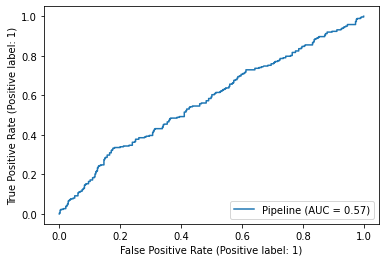

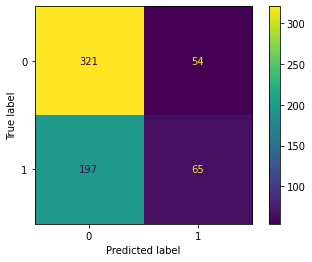

In [157]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler  ## for data centering 
from sklearn.pipeline import make_pipeline   ## sequential pipelining
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

mysvm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
mysvm = mysvm.fit(X_train.toarray(), train_label)

## test
#print(mysvm.predict(X_test[0]), test_label[0])

train_preds = mysvm.predict(X_train.toarray())
print("Train Accuracy: ", 100*accuracy_score(train_preds, train_label))

test_preds = mysvm.predict(X_test.toarray())
print("Test Accuracy: ", 100*accuracy_score(test_preds, test_label))

## visualize
RocCurveDisplay.from_estimator(mysvm, X_test.toarray(), test_label)
ConfusionMatrixDisplay.from_estimator(mysvm, X_test.toarray(), test_label)
plt.show()


## MLP (neural network) Classifier

Train Accuracy:  100.0
Test Accuracy:  61.38147566718995


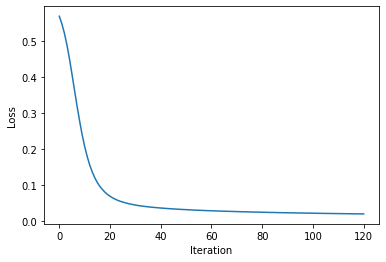

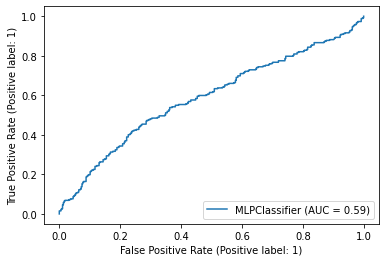

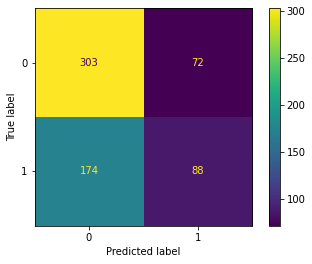

In [167]:
from sklearn.neural_network import MLPClassifier

##hyperparams
h_lrs = 7
acts = 'relu' #'identity', 'logistic', 'tanh'
solver = 'adam' #'sgd'
l2_reg = 0.01
batch_size = 'auto'
lr_init = 0.01 #0.001
lr_type = 'adaptive' #'constant', 'invscaling', 'adaptive'
early_stopping = False #True
validation_fraction = 0.05

mymlp = MLPClassifier(hidden_layer_sizes=h_lrs, activation=acts, early_stopping=early_stopping, 
                    validation_fraction=validation_fraction, solver=solver, 
                      learning_rate_init = lr_init, learning_rate=lr_type, 
                      alpha = l2_reg, batch_size=batch_size, max_iter=10000)

mymlp = mymlp.fit(X_train, train_label)

loss_curve = mymlp.loss_curve_

plt.plot(loss_curve)
plt.xlabel("Iteration")
plt.ylabel("Loss")

## test
#print(mymlp.predict(X_test[0]), test_label[0])

train_preds = mymlp.predict(X_train.toarray())
print("Train Accuracy: ", 100*accuracy_score(train_preds, train_label))

test_preds = mymlp.predict(X_test.toarray())
print("Test Accuracy: ", 100*accuracy_score(test_preds, test_label))


## visualize
RocCurveDisplay.from_estimator(mymlp, X_test.toarray(), test_label)
ConfusionMatrixDisplay.from_estimator(mymlp, X_test.toarray(), test_label)
plt.show()


# TFIDF PART

In [150]:
# fitting and defining tf-idf from our corpus
tfidfVec = TfidfVectorizer(preprocessor=preprocess_text, stop_words='english')
tfidfVec = tfidfVec.fit(merged_data)

## get tfidf feat rep
X_train = tfidfVec.transform(train_data)  
X_test = tfidfVec.transform(test_data)

## display
tf_idf_df=pd.DataFrame(X_train.toarray(),columns=tfidfVec.get_feature_names_out())
display(tf_idf_df.head(5).loc[:,tf_idf_df.head(5).any()])
print(tf_idf_df.head(5).loc[:,tf_idf_df.head(5).any()].iloc[:, : 10].to_markdown())

,analysis,argument,based,chunk,coherence,comprehension,decoder,evaluation,interactions,japanese,...,morphology,multi,neural,predicate,prerequisite,readability,reading,skills,structure,translation
0,0.14581,0.321137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.308037,0.339601,...,0.000000,0.20798,0.102000,0.679202,0.000000,0.000000,0.000000,0.000000,0.289573,0.000000
1,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.554981,0.00000,0.166691,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.415684
2,0.00000,0.000000,0.309153,0.566028,0.000000,0.000000,0.482643,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.170009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.423958
3,0.00000,0.000000,0.000000,0.000000,0.000000,0.329165,0.000000,0.338603,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.386034,0.386034,0.338603,0.386034,0.000000,0.000000
4,0.00000,0.000000,0.000000,0.000000,0.671563,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.201707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


|    |   analysis |   argument |    based |    chunk |   coherence |   comprehension |   decoder |   evaluation |   interactions |   japanese |
|---:|-----------:|-----------:|---------:|---------:|------------:|----------------:|----------:|-------------:|---------------:|-----------:|
|  0 |    0.14581 |   0.321137 | 0        | 0        |    0        |        0        |  0        |     0        |       0.308037 |   0.339601 |
|  1 |    0       |   0        | 0        | 0        |    0        |        0        |  0        |     0        |       0        |   0        |
|  2 |    0       |   0        | 0.309153 | 0.566028 |    0        |        0        |  0.482643 |     0        |       0        |   0        |
|  3 |    0       |   0        | 0        | 0        |    0        |        0.329165 |  0        |     0.338603 |       0        |   0        |
|  4 |    0       |   0        | 0        | 0        |    0.671563 |        0        |  0        |     0        |       0        |   0  

In [15]:
# Dimension reduction on TF-IDF using SVD
on_svd = False

'''
svd = TruncatedSVD(n_components=500, n_iter=10, random_state=42)
X_new = svd.fit_transform(X)
X_train_svd = X_new[0:len(train_data)]
X_test_svd = X_new[len(train_data):]
'''

'\nsvd = TruncatedSVD(n_components=500, n_iter=10, random_state=42)\nX_new = svd.fit_transform(X)\nX_train_svd = X_new[0:len(train_data)]\nX_test_svd = X_new[len(train_data):]\n'

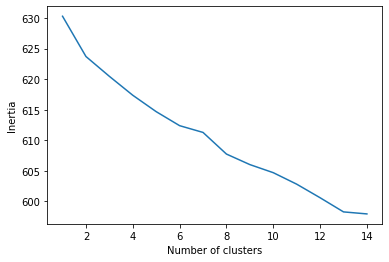

In [16]:
# cluster documents based on tf-idf scores
distortions = []
K = range(1,15)

for k in K:
    model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10)
    if(on_svd):
        model.fit(X_train_svd)
    else:
        model.fit(X_train)
    distortions.append(model.inertia_)

plt.plot(K, distortions)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
# print(distortions)

# Choosing the best k from elbow method.
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=10)
if(on_svd):
    model.fit(X_train_svd)
else:
    model.fit(X_train)

Top terms per cluster:


/home/inspire/miniconda3/envs/ml_hw3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


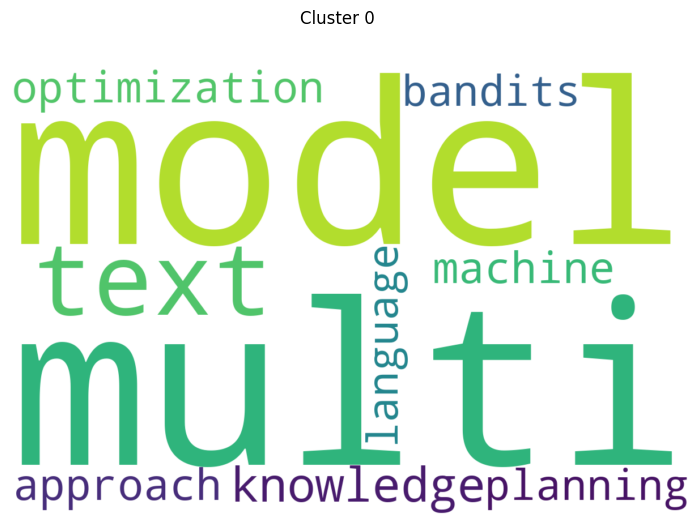

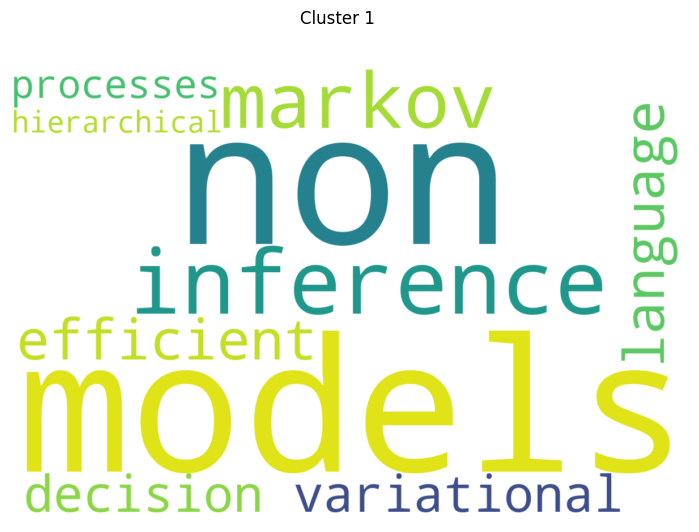

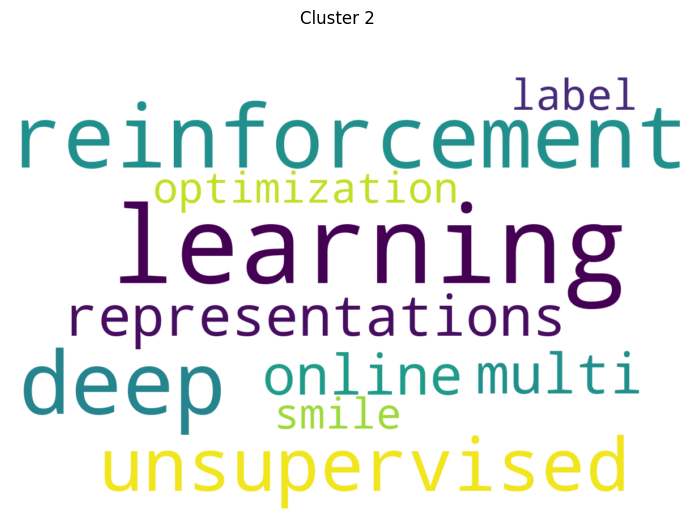

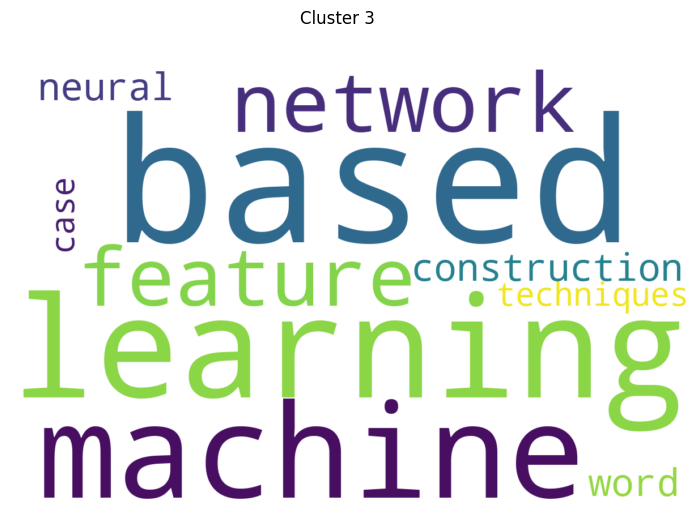

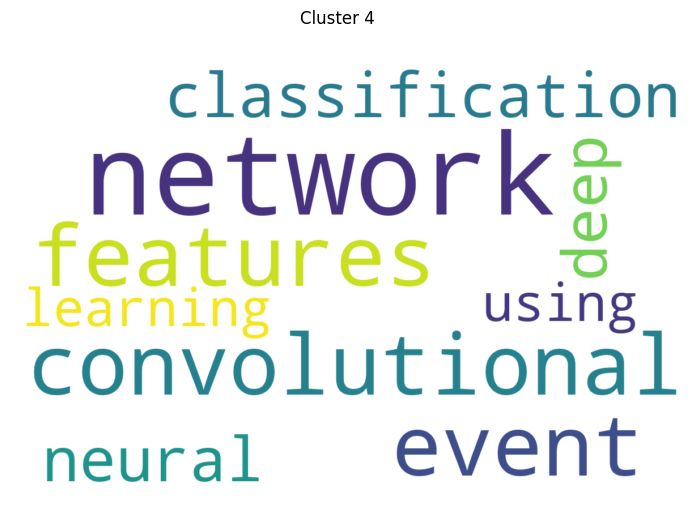

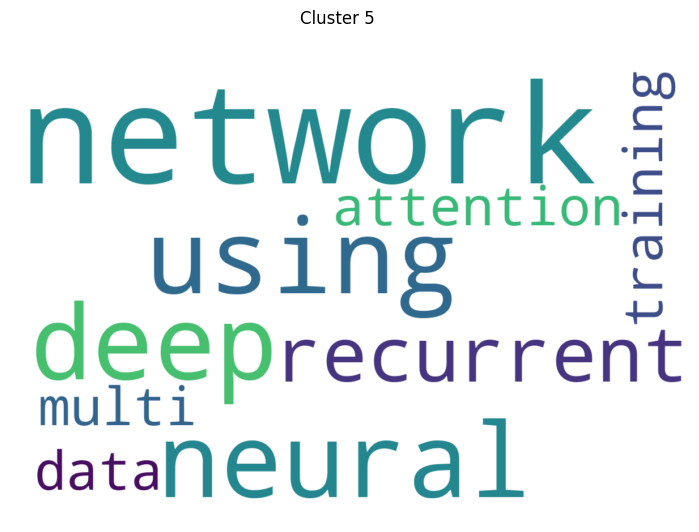

In [17]:
# Print top terms per cluster and generate word clouds
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    # print("Cluster %d:" % i)
    words = ""
    for ind in order_centroids[i, :10]:
        words = words + terms[ind] + " "
        # print (' %s' % terms[ind])
    wordcloud = WordCloud(width=1200, height=800, background_color="white").generate(words)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    fig.suptitle(f"Cluster {i}")
    plt.show()

In [18]:
# Testing the Model
# Predict the cluster association of each paper
prediction = model.predict(X_test)
print(X_train.shape)
print(X_test.shape)
df = pd.DataFrame(list(zip(test_title, prediction)), columns =['Title', 'Cluster ID'])
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# display(df)
print(df.head(10).loc[:,df.head(10).any()].to_markdown())
# display(df.loc[df['Cluster ID'] == 1])

(637, 1867)
(637, 1867)
|    | Title                                                    |
|---:|:---------------------------------------------------------|
|  0 | Cross-lingual Name Tagging and Linking for 282 Languages |
|  1 | Cross-lingual Name Tagging and Linking for 282 Languages |
|  2 | Cross-lingual Name Tagging and Linking for 282 Languages |
|  3 | Cross-lingual Name Tagging and Linking for 282 Languages |
|  4 | Cross-lingual Name Tagging and Linking for 282 Languages |
|  5 | Cross-lingual Name Tagging and Linking for 282 Languages |
|  6 | Cross-lingual Name Tagging and Linking for 282 Languages |
|  7 | Fisher Motion Descriptor for Multiview Gait Recognition  |
|  8 | Fisher Motion Descriptor for Multiview Gait Recognition  |
|  9 | Fisher Motion Descriptor for Multiview Gait Recognition  |


Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/555 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg opt

KMeans(max_iter=1000, n_clusters=6)

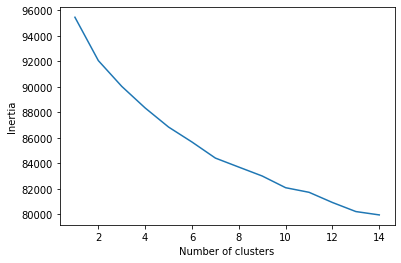

In [17]:
# BERT Encoding using SentenceTransformer and pre-trained distillbert model

embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
embeddings = embedder.encode(merged_data)

X_train = embeddings[0:len(train_data)]
X_test = embeddings[len(train_data):]

# K-means clustering on BERT encoding

bert_distortions = []
K = range(1,15)
for k in K:
    bert_model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10)
    bert_model.fit(X_train)
    bert_distortions.append(bert_model.inertia_)

plt.plot(K, bert_distortions)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
# print(distortions)

# Choosing the best k from elbow method.
true_k = 6
bert_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=10)
bert_model.fit(X_train)

In [18]:
# Print top terms per cluster and generate word clouds for BERT model
print("Top terms per cluster:")
bert_order_centroids = bert_model.cluster_centers_.argsort()[:, ::-1]
terms = embeddings.get_feature_names()
for i in range(true_k):
    # print("Cluster %d:" % i)
    words = ""
    for ind in bert_order_centroids[i, :10]:
        words = words + terms[ind] + " "
        # print (' %s' % terms[ind])
    wordcloud = WordCloud(width=1200, height=800, background_color="white").generate(words)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    fig.suptitle(f"Cluster {i}")
    plt.show()

Top terms per cluster:


AttributeError: 'numpy.ndarray' object has no attribute 'get_feature_names'

In [ ]:
# Predict the clusters using BERT encoded model
bert_prediction = bert_model.predict(X_test)
print(X_train.shape)
print(X_test.shape)
bert_df = pd.DataFrame(list(zip(test_title, prediction)), columns =['Title', 'Cluster ID'])
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# display(df)
print(bert_df.head(10).loc[:,bert_df.head(10).any()].to_markdown())
# display(df.loc[df['Cluster ID'] == 1])